In [1]:
%matplotlib inline

import re  #regular expression
import numpy as np  #for multidimensional array and matrices
import pandas as pd  #for data manipulation and analysis
import matplotlib.pyplot as plt  
import seaborn as sns  # visualization library based on matplotlib
import plotly.offline as py  #Instead of saving the graphs to a server, your data and graphs will remain in your local system
import plotly.graph_objs as go
import plotly.tools as tls
from bs4 import BeautifulSoup
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

py.init_notebook_mode(connected=True)

In [2]:
train = pd.read_csv('D:/projects/personality_prediction/mbti_1/mbti_1.csv')
us = pd.read_csv('D:/projects/personality_prediction/meta-kaggle/Users.csv')
ps = pd.read_csv('D:/projects/personality_prediction/meta-kaggle/ForumMessages.csv')
mbti = {'I':'Introversion', 'E':'Extroversion', 'N':'Intuition', 
        'S':'Sensing', 'T':'Thinking', 'F': 'Feeling', 
        'J':'Judging', 'P': 'Perceiving'}

In [3]:
train.shape #no of rows(entries) * no of columns(attributes)

(8675, 2)

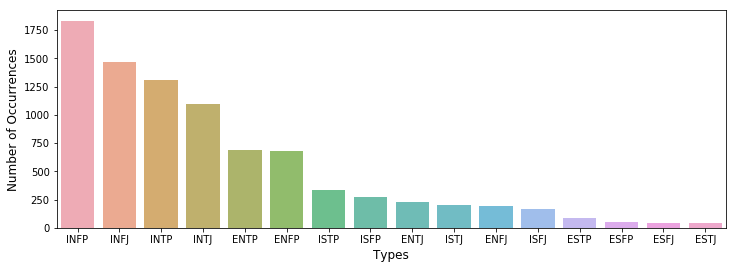

In [4]:
# We take a look to the classes. It looks like it is a very unbalanced dataset:

cnt_srs = train['type'].value_counts() #Returns object containing counts of unique values.

plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

In [5]:
ps['Message'] = ps['Message'].fillna('')  #Replace all NaN elements with ' '

In [6]:
ps_join = ps.groupby('Id')['Message'].agg(lambda col: ' '.join(col)).reset_index()  #to get a union of strings
#.reset_index() : Generate a new DataFrame or Series with the index reset.

In [7]:
# ExtraTreesClassifier with SVD  We want to evaluate its performance.

etc = ExtraTreesClassifier(n_estimators = 20, max_depth=4, n_jobs = -1)
#implements a meta estimator that fits a number of randomized decision trees on various sub-samples of the dataset 
#and use avg to improve the predictive accuracy and control over-fitting.
#n_estimators : number of trees in the forest. n_jobs : jobs to run in parallel.If -1, then the no of jobs is set to no of cores.

tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words='english') 
# term frequency-inverse document frequency,
#Convert a collection of raw documents to a matrix of TF-IDF features.

tsvd = TruncatedSVD(n_components=10)
# Dimensionality reduction using truncated SVD (aka LSA: latent semantic analysis) n_components : Desired dimensionality of output data

model = Pipeline([('tfidf1', tfidf), ('tsvd1', tsvd), ('etc', etc)])
#Its purpose is to aggregate a number of data transformation steps, and a model operating on the result of these transformations,
#into a single object that can then be used in place of a simple estimator

In [8]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1) #Provides train/test indices to split data in train/test sets.

In [9]:
np.random.seed(1) #seed() sets the integer starting value used in generating random numbers, same seed => same no each time 
# makes the random numbers predictable

scoring = {'acc': 'accuracy',
           'neg_log_loss': 'neg_log_loss',
           'f1_micro': 'f1_micro'}

results = cross_validate(model, train['posts'], train['type'], cv=kfolds, 
                          scoring=scoring, n_jobs=-1)
#Evaluate metric(s) by cross-validation and also record fit/score times.

In [10]:
print("CV Accuracy: {:0.4f} (+/- {:0.4f})".format(np.mean(results['test_acc']),
                                                          np.std(results['test_acc'])))

print("CV F1: {:0.4f} (+/- {:0.4f})".format(np.mean(results['test_f1_micro']),
                                                          np.std(results['test_f1_micro'])))

print("CV Logloss: {:0.4f} (+/- {:0.4f})".format(np.mean(-1*results['test_neg_log_loss']),
                                                          np.std(-1*results['test_neg_log_loss'])))

CV Accuracy: 0.2900 (+/- 0.0119)
CV F1: 0.2900 (+/- 0.0119)
CV Logloss: 2.1416 (+/- 0.0123)


In [11]:
#As the dataset is very unbalanced F1 score is a better metric than accuracy
#Alternative models
#Let's try if we can find a more accuracy model, although we haven't got a lot of data

In [12]:
def cleanText(text):
    text = BeautifulSoup(text, "html.parser").text  #for pulling data out of HTML and XML files
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    return text

In [13]:
train['clean_posts'] = train['posts'].apply(cleanText)

In [14]:
#Naive Bayes

np.random.seed(1)

# Convert a collection of text documents to a matrix of token counts
tfidf2 = CountVectorizer(ngram_range=(1, 1), 
                         stop_words='english',
                         lowercase = True, 
                         max_features = 5000)

model_nb = Pipeline([('tfidf1', tfidf2), ('nb', MultinomialNB())]) # Naive Bayes classifier for multinomial models

results_nb = cross_validate(model_nb, train['clean_posts'], train['type'], cv=kfolds, 
                          scoring=scoring, n_jobs=-1)

In [15]:
print("CV Accuracy: {:0.4f} (+/- {:0.4f})".format(np.mean(results_nb['test_acc']),
                                                          np.std(results_nb['test_acc'])))

print("CV F1: {:0.4f} (+/- {:0.4f})".format(np.mean(results_nb['test_f1_micro']),
                                                          np.std(results_nb['test_f1_micro'])))

print("CV Logloss: {:0.4f} (+/- {:0.4f})".format(np.mean(-1*results_nb['test_neg_log_loss']),
                                                          np.std(-1*results_nb['test_neg_log_loss'])))

CV Accuracy: 0.5618 (+/- 0.0111)
CV F1: 0.5618 (+/- 0.0111)
CV Logloss: 6.3275 (+/- 0.3023)


In [16]:
#Logistic Regression

np.random.seed(1)

tfidf2 = CountVectorizer(ngram_range=(1, 1), stop_words='english',
                                                 lowercase = True, max_features = 5000)

model_lr = Pipeline([('tfidf1', tfidf2), ('lr', LogisticRegression(class_weight="balanced", C=0.005))])

results_lr = cross_validate(model_lr, train['clean_posts'], train['type'], cv=kfolds, 
                          scoring=scoring, n_jobs=-1)

In [17]:
print("CV Accuracy: {:0.4f} (+/- {:0.4f})".format(np.mean(results_lr['test_acc']),
                                                          np.std(results_lr['test_acc'])))

print("CV F1: {:0.4f} (+/- {:0.4f})".format(np.mean(results_lr['test_f1_micro']),
                                                          np.std(results_lr['test_f1_micro'])))

print("CV Logloss: {:0.4f} (+/- {:0.4f})".format(np.mean(-1*results_lr['test_neg_log_loss']),
                                                          np.std(-1*results_lr['test_neg_log_loss'])))

CV Accuracy: 0.6724 (+/- 0.0096)
CV F1: 0.6724 (+/- 0.0096)
CV Logloss: 1.2352 (+/- 0.0227)


In [18]:
#Is this model overtitting? could we have a better model with more data? Let's see the learning curve:

train_sizes, train_scores, test_scores = \
    learning_curve(model_lr, train['clean_posts'], train['type'], cv=kfolds, n_jobs=-1, 
                   scoring="f1_micro", train_sizes=np.linspace(.1, 1.0, 10), random_state=1)
# Determines cross-validated training and test scores for different training set sizes.

In [19]:
def plot_learning_curve(X, y, train_sizes, train_scores, test_scores, title='', ylim=None, figsize=(14,8)):

    plt.figure(figsize=figsize)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

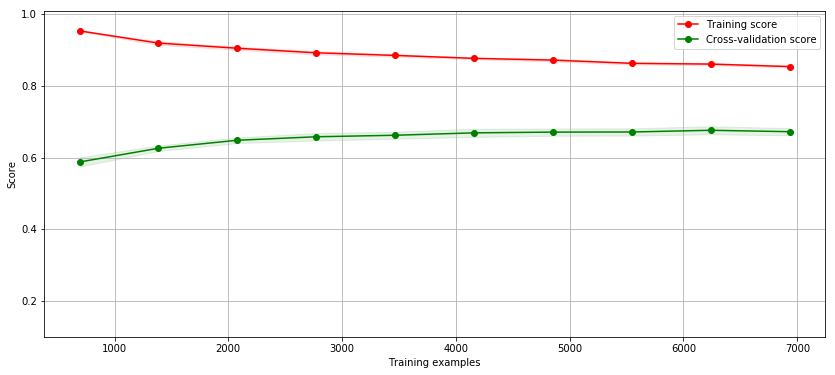

In [20]:
import matplotlib.pyplot as plt

plot_learning_curve(train['posts'], train['type'], train_sizes, 
                    train_scores, test_scores, ylim=(0.1, 1.01), figsize=(14,6))
plt.show()

In [21]:
# It looks like that with more data the model gets better and that it is not overfitting.

In [22]:
#Kaggle users personality
#Let's apply our last model to whole kaggle users comments. Let's see what is the most common kaggle user personalities

ps_join['clean_comments'] = ps_join['Message'].apply(cleanText)

c:\users\ankur\appdata\local\programs\python\python36-32\lib\site-packages\bs4\__init__.py:282: UserWarning:

"http://www-stat.stanford.edu/~tibs/ElemStatLearn/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.



In [23]:
model_lr.fit(train['clean_posts'], train['type'])
pred_all = model_lr.predict(ps_join['clean_comments'])

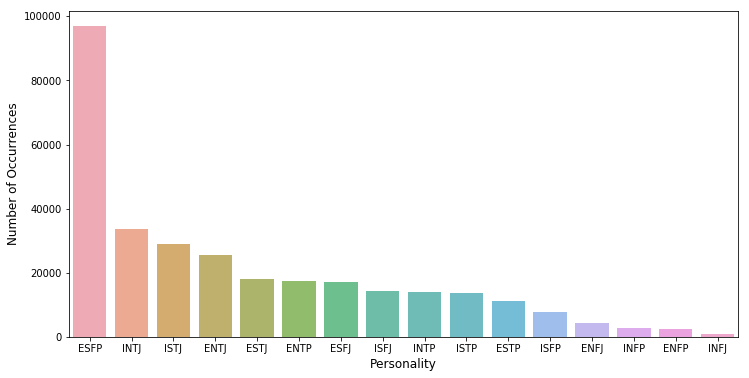

In [24]:
cnt_all = np.unique(pred_all, return_counts=True)

pred_df = pd.DataFrame({'personality': cnt_all[0], 'count': cnt_all[1]},
                      columns=['personality', 'count'], index=None)

pred_df.sort_values('count', ascending=False, inplace=True)

plt.figure(figsize=(12,6))
sns.barplot(pred_df['personality'], pred_df['count'], alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Personality', fontsize=12)
plt.show()

In [25]:
pred_df['percent'] = pred_df['count']/pred_df['count'].sum()

In [26]:
pred_df['description'] = pred_df['personality'].apply(lambda x: ' '.join([mbti[l] for l in list(x)]))

In [27]:
pred_df

,personality,count,percent,description
5,ESFP,96944,0.314408,Extroversion Sensing Feeling Perceiving
10,INTJ,33768,0.109516,Introversion Intuition Thinking Judging
14,ISTJ,28960,0.093923,Introversion Sensing Thinking Judging
2,ENTJ,25518,0.082760,Extroversion Intuition Thinking Judging
6,ESTJ,18151,0.058867,Extroversion Sensing Thinking Judging
3,ENTP,17288,0.056068,Extroversion Intuition Thinking Perceiving
4,ESFJ,17035,0.055248,Extroversion Sensing Feeling Judging
12,ISFJ,14159,0.045920,Introversion Sensing Feeling Judging
11,INTP,13875,0.044999,Introversion Intuition Thinking Perceiving
15,ISTP,13616,0.044159,Introversion Sensing Thinking Perceiving


In [28]:
labels = pred_df['description']
sizes = pred_df['percent']*100

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Kaggle Personality Distribution'
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)